In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.concat(
    [
        pd.read_excel(os.path.join("data", f), engine="xlrd")
        for f in sorted(os.listdir("data"))
        if f.lower().endswith(".xls")
    ],
    ignore_index=True
)


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def market_plotter(df, mkt, fut_only=True):
    d = df.copy()

    # --- dates ---
    if "Report_Date_as_MM_DD_YYYY" in d.columns:
        d["report_date"] = pd.to_datetime(d["Report_Date_as_MM_DD_YYYY"])
    elif "As_of_Date_In_Form_YYMMDD" in d.columns:
        d["report_date"] = pd.to_datetime(d["As_of_Date_In_Form_YYMMDD"].astype(str), format="%y%m%d")
    else:
        raise KeyError("No recognised report date column found.")

    # --- market filter ---
    if "Market_and_Exchange_Names" not in d.columns:
        raise KeyError("Expected column 'Market_and_Exchange_Names' not found.")

    m = d["Market_and_Exchange_Names"].astype(str).str.contains(str(mkt), case=False, na=False)

    if fut_only and "FutOnly_or_Combined" in d.columns:
        m &= (d["FutOnly_or_Combined"].astype(str).str.lower() == "futonly")

    d = d.loc[m].sort_values("report_date").copy()
    if d.empty:
        raise ValueError(f"No rows matched mkt={mkt!r} (check spelling / substring match).")

    # --- helpers for annoying column name variants ---
    def pick(*cands):
        for c in cands:
            if c in d.columns:
                return c
        raise KeyError(f"None of these columns exist: {cands}")

    c_oi   = pick("Open_Interest_All", "Open_Interest_ALL")
    c_pl   = pick("Prod_Merc_Positions_Long_ALL",  "Prod_Merc_Positions_Long_All")
    c_ps   = pick("Prod_Merc_Positions_Short_ALL", "Prod_Merc_Positions_Short_All")
    c_sl   = pick("Swap_Positions_Long_All", "Swap_Positions_Long_ALL")
    c_ss   = pick("Swap__Positions_Short_All", "Swap_Positions_Short_All", "Swap__Positions_Short_ALL", "Swap_Positions_Short_ALL")
    c_mml  = pick("M_Money_Positions_Long_ALL",  "M_Money_Positions_Long_All")
    c_mms  = pick("M_Money_Positions_Short_ALL", "M_Money_Positions_Short_All")
    c_ol   = pick("Other_Rept_Positions_Long_ALL",  "Other_Rept_Positions_Long_All")
    c_os   = pick("Other_Rept_Positions_Short_ALL", "Other_Rept_Positions_Short_All")

    # --- nets ---
    d["net_prod"]  = d[c_pl]  - d[c_ps]
    d["net_swap"]  = d[c_sl]  - d[c_ss]
    d["net_mm"]    = d[c_mml] - d[c_mms]
    d["net_other"] = d[c_ol]  - d[c_os]
    d["open_interest"] = d[c_oi]

    # --- style ---
    plt.rcParams.update({
        "figure.facecolor": "black",
        "axes.facecolor": "black",
        "savefig.facecolor": "black",
        "text.color": "white",
        "axes.labelcolor": "white",
        "axes.edgecolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "font.size": 11,
    })

    fig, ax = plt.subplots(figsize=(14, 6))

    x = mdates.date2num(d["report_date"].to_numpy())
    w = 1.2
    offs = np.array([-1.8, -0.6, 0.6, 1.8])

    c_prod  = "#ff3b30"
    c_swap  = "#ffd60a"
    c_mm    = "#0a84ff"
    c_other = "#ff9f0a"
    c_oi    = "#34c759"

    ax.bar(x + offs[0], d["net_prod"],  width=w, color=c_prod,  label="Producer/Merchant", linewidth=0)
    ax.bar(x + offs[1], d["net_swap"],  width=w, color=c_swap,  label="Swap Dealers",      linewidth=0)
    ax.bar(x + offs[2], d["net_mm"],    width=w, color=c_mm,    label="Managed Money",     linewidth=0)
    ax.bar(x + offs[3], d["net_other"], width=w, color=c_other, label="Other Reportables", linewidth=0)

    ax.axhline(0, color="white", linewidth=1, alpha=0.8)
    ax.set_title(f"{mkt} — Net positions (COT-style)", pad=10, fontsize=14, fontweight="bold")
    ax.set_ylabel("Contracts")

    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b-%y"))
    for t in ax.get_xticklabels():
        t.set_rotation(90)
        t.set_ha("center")
        t.set_fontsize(8)

    ax2 = ax.twinx()
    ax2.plot(d["report_date"], d["open_interest"], color=c_oi, linewidth=2.0, label="Open Interest")
    ax2.set_ylabel("Open interest")
    ax2.tick_params(colors="white")
    ax2.spines["right"].set_color("white")

    for s in ax.spines.values():
        s.set_color("white")

    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    leg = ax.legend(h1 + h2, l1 + l2, loc="upper left", frameon=False, ncol=5)
    for txt in leg.get_texts():
        txt.set_color("white")

    plt.tight_layout()
    plt.show()


In [29]:
# df["Market_and_Exchange_Names"].unique()


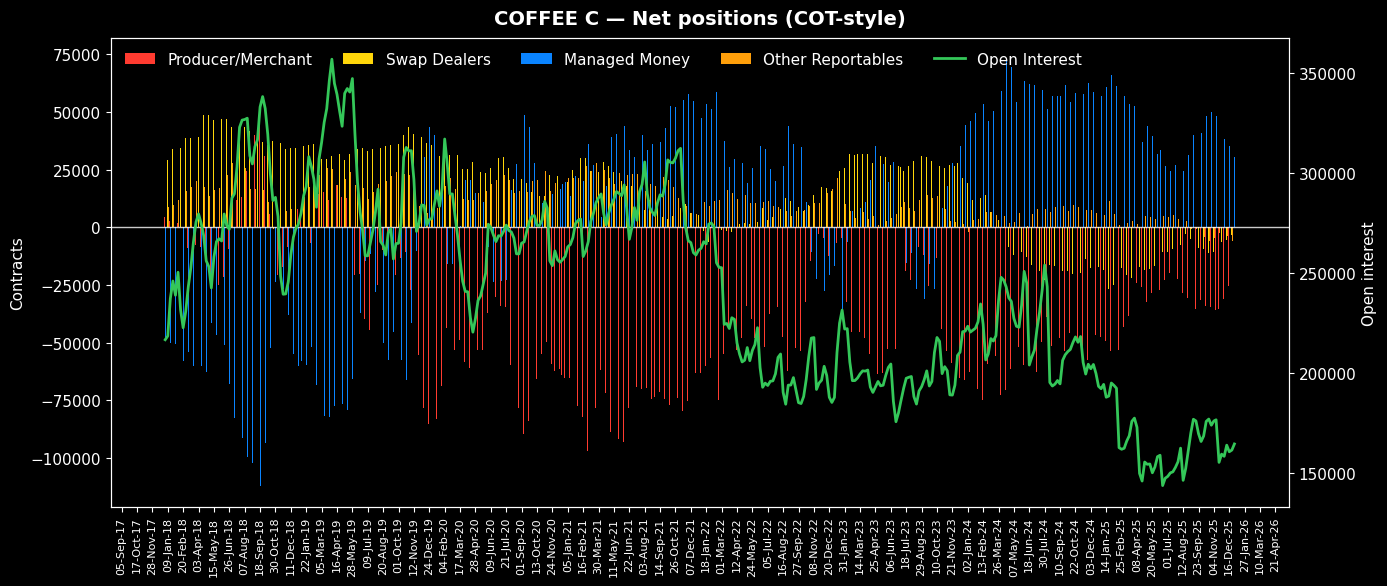

In [24]:
mkt = 'COFFEE C'
market_plotter(df, mkt)


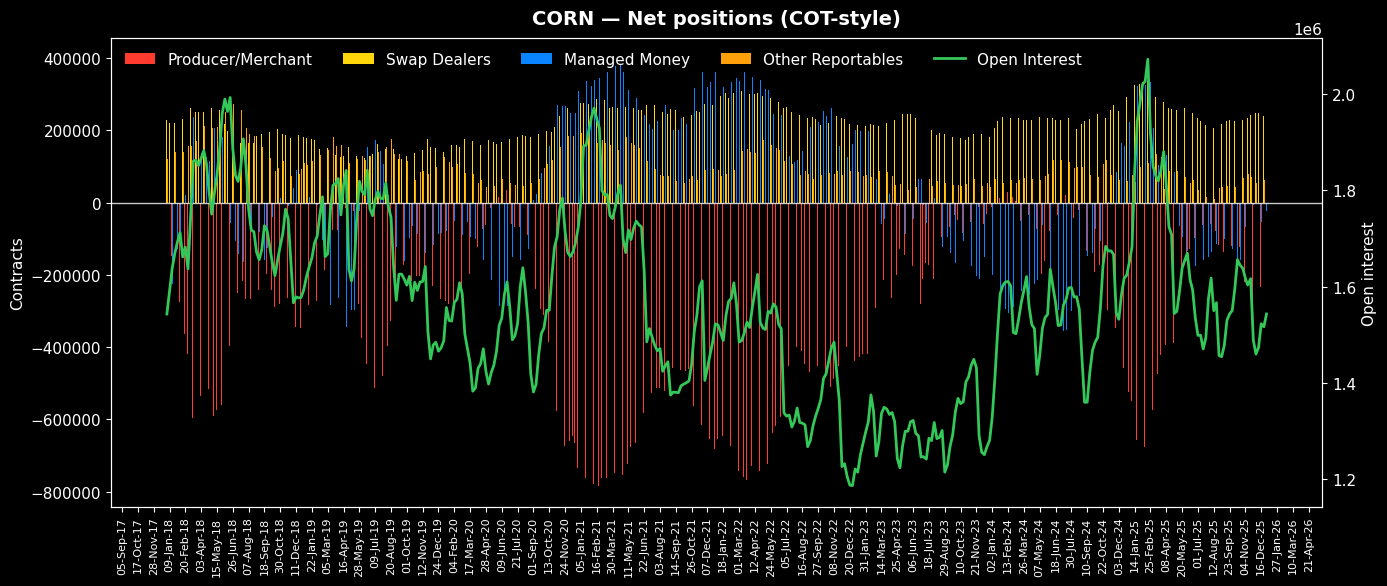

In [25]:
mkt = 'CORN'
market_plotter(df, mkt)


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter


def position_plotter(df, mkt, fut_only=True, exact=False):
    d = df.copy()

    # --- date ---
    if "Report_Date_as_MM_DD_YYYY" in d.columns:
        d["report_date"] = pd.to_datetime(d["Report_Date_as_MM_DD_YYYY"])
    elif "As_of_Date_In_Form_YYMMDD" in d.columns:
        d["report_date"] = pd.to_datetime(d["As_of_Date_In_Form_YYMMDD"].astype(str), format="%y%m%d")
    else:
        raise KeyError("No recognised report date column found.")

    # --- market filter ---
    if "Market_and_Exchange_Names" not in d.columns:
        raise KeyError("Expected column 'Market_and_Exchange_Names' not found.")

    s = d["Market_and_Exchange_Names"].astype(str)
    if exact:
        m = s.str.upper().eq(str(mkt).upper())
    else:
        m = s.str.contains(str(mkt), case=False, na=False)

    if fut_only and "FutOnly_or_Combined" in d.columns:
        m &= (d["FutOnly_or_Combined"].astype(str).str.lower() == "futonly")

    d = d.loc[m].sort_values("report_date").copy()
    if d.empty:
        raise ValueError(f"No rows matched mkt={mkt!r} (try exact=False/True or check market string).")

    # --- helper for column variants ---
    def pick(*cands):
        for c in cands:
            if c in d.columns:
                return c
        raise KeyError(f"None of these columns exist: {cands}")

    c_pl  = pick("Prod_Merc_Positions_Long_ALL",  "Prod_Merc_Positions_Long_All")
    c_ps  = pick("Prod_Merc_Positions_Short_ALL", "Prod_Merc_Positions_Short_All")
    c_sl  = pick("Swap_Positions_Long_All", "Swap_Positions_Long_ALL")
    c_ss  = pick("Swap__Positions_Short_All", "Swap_Positions_Short_All", "Swap__Positions_Short_ALL", "Swap_Positions_Short_ALL")
    c_mml = pick("M_Money_Positions_Long_ALL",  "M_Money_Positions_Long_All")
    c_mms = pick("M_Money_Positions_Short_ALL", "M_Money_Positions_Short_All")
    c_ol  = pick("Other_Rept_Positions_Long_ALL",  "Other_Rept_Positions_Long_All")
    c_os  = pick("Other_Rept_Positions_Short_ALL", "Other_Rept_Positions_Short_All")

    # nonreportable is not always present in disagg futures-only tables
    nonrep_long = next((c for c in ["NonRept_Positions_Long_All", "NonRept_Positions_Long_ALL"] if c in d.columns), None)
    nonrep_short = next((c for c in ["NonRept_Positions_Short_All", "NonRept_Positions_Short_ALL"] if c in d.columns), None)

    # --- nets by group ---
    d["net_prod"]  = d[c_pl]  - d[c_ps]
    d["net_swap"]  = d[c_sl]  - d[c_ss]
    d["net_mm"]    = d[c_mml] - d[c_mms]
    d["net_other"] = d[c_ol]  - d[c_os]

    # --- map to the 3 lines ---
    # Commercial often taken as producer + swap + other reportables in the disaggregated view
    d["Commercial"]    = d["net_prod"] + d["net_swap"] + d["net_other"]
    d["NonCommercial"] = d["net_mm"]

    if nonrep_long and nonrep_short:
        d["Non Rept"] = d[nonrep_long] - d[nonrep_short]
    else:
        d["Non Rept"] = np.nan

    # --- plot ---
    fig = plt.figure(figsize=(12, 5.5))
    ax = fig.add_axes([0.08, 0.22, 0.86, 0.68])

    ax.plot(d["report_date"], d["Commercial"],    marker="o", markersize=3, linewidth=2, label="Commercial")
    ax.plot(d["report_date"], d["NonCommercial"], marker="o", markersize=3, linewidth=2, label="NonCommercial")

    if np.isfinite(d["Non Rept"]).any():
        ax.plot(d["report_date"], d["Non Rept"], marker="o", markersize=3, linewidth=2, label="Non Rept")

    ax.axhline(0, linewidth=1)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))

    ax.set_title(f"{mkt} — Net Positions", loc="left", fontweight="bold", fontsize=14)

    ax.grid(True, axis="y", linestyle="--", alpha=0.35)
    ax.grid(True, axis="x", alpha=0.15)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.18), ncol=3, frameon=False, handlelength=3)

    plt.show()



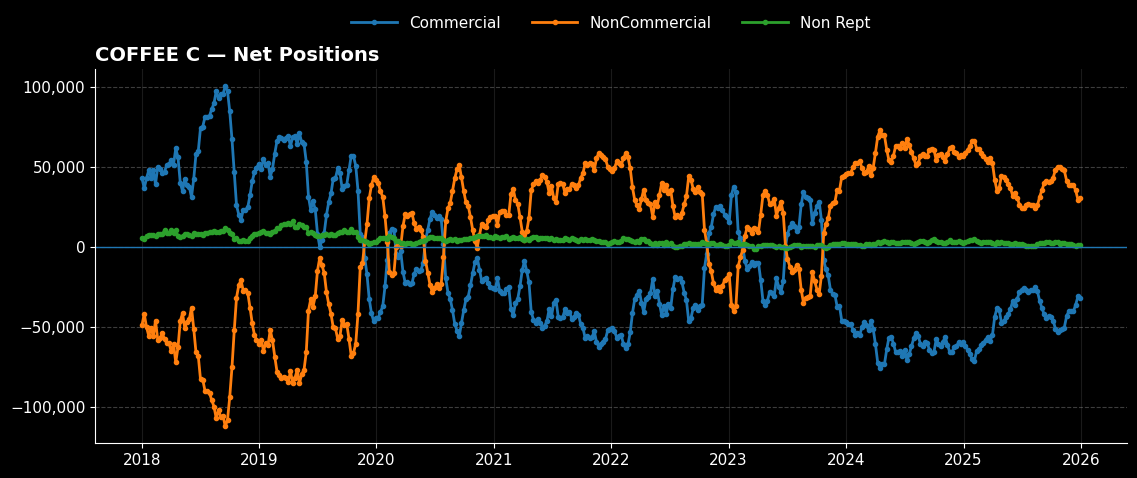

In [19]:
mkt = "COFFEE C"
position_plotter(df, mkt)


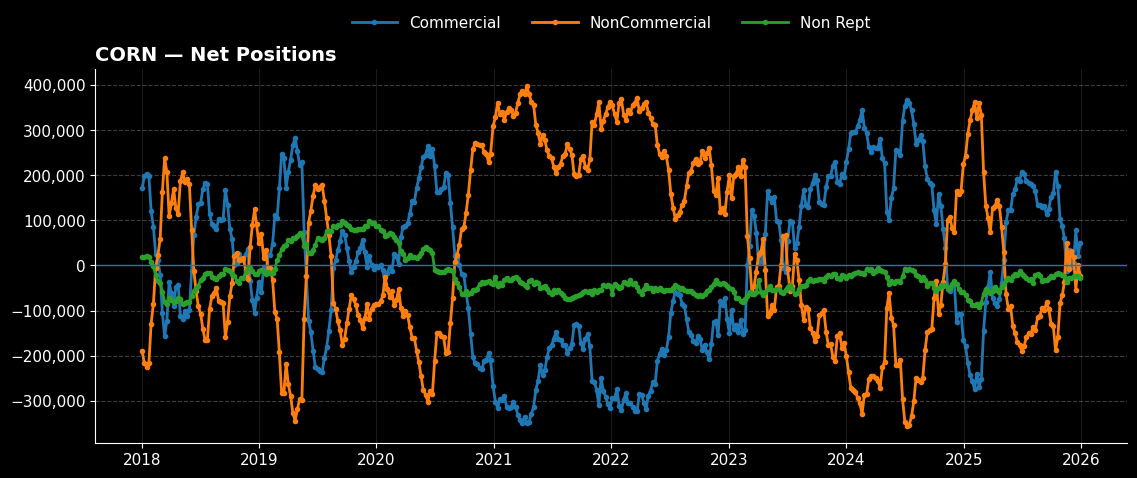

In [20]:
mkt = "CORN"
position_plotter(df, mkt)
